In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import adabmDCA

from adabmDCA.fasta import get_tokens, import_from_fasta, compute_weights
from adabmDCA.stats import get_freq_single_point, get_freq_two_points
from adabmDCA.functional import one_hot
from adabmDCA.utils import init_parameters, init_chains, get_device, get_dtype, get_mask_save
from adabmDCA.sampling import get_sampler
from adabmDCA.training import train_graph
from adabmDCA.io import save_params, save_chains, load_params

/Users/scrotti/adabmDCApy/adabmDCA/training.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [14]:
device = get_device("")
dtype = get_dtype("float32")

Running on CPU


In [22]:
alphabet = "rna"
tokens = get_tokens(alphabet)
path_data = "../example_data/RF00379.fasta"
headers, sequences = import_from_fasta(path_data, tokens=tokens, filter_sequences=True, remove_duplicates=True)
M, L, q = len(sequences), len(sequences[0]), len(tokens)
print(f"Number of sequences in the MSA: M={M}")
print(f"Length of the MSA: L={L}")
print(f"Number of Potts states: q={q}")

Number of sequences in the MSA: M=3646
Length of the MSA: L=136
Number of Potts states: q=5


In [24]:
msa_enc = torch.tensor(sequences, device=device, dtype=torch.int32)
weights = torch.ones(M, device=device, dtype=dtype)
M_eff = int(weights.sum())
msa_oh = one_hot(msa_enc, num_classes=q).to(dtype)

In [28]:
pseudo_count = 0.001 # @param ["1/M_eff", "0.01", "0.001", "0.0001"]{"type":"raw"}
nchains = 10000 # @param {"type":"integer"}
nsweeps = 10 # @param {"type":"integer"}
target = 0.90 # @param {"type":"number"}
lr = 0.01 # @param {"type":"number"}
sampler_alg = "gibbs" # @param ["gibbs", "metropolis"]

pseudocount = float(pseudo_count)
    
fi_target = get_freq_single_point(data=msa_oh, weights=weights, pseudo_count=pseudocount)
fij_target = get_freq_two_points(data=msa_oh, weights=weights, pseudo_count=pseudocount)

sampler = torch.jit.script(get_sampler(sampler_alg))
print("Using sampler:", sampler_alg);

Using sampler: gibbs


In [30]:
params = init_parameters(fi=fi_target)
chains = init_chains(num_chains=nchains, L=L, q=q, device=device, fi=fi_target)
log_weights = torch.zeros(len(chains), device=device)
# Mask for removing the autocorrelations
mask = torch.ones(size=(L, q, L, q), dtype=torch.bool, device=device)
mask[torch.arange(L), :, torch.arange(L), :] = 0
# Mask for saving only the upper diagnal part of the weight_matrix
mask_save = get_mask_save(L=L, q=q, device=device)

In [33]:
chains, params, log_weights, history = train_graph(
    sampler=sampler,
    chains=chains,
    fi=fi_target,
    fij=fij_target,
    params=params,
    mask=mask,
    nsweeps=nsweeps,
    lr=lr,
    max_epochs=1000,
    target_pearson=target,
    )

 13.33%[###                    ] Pearson: 0.120/0.9 [00:00]

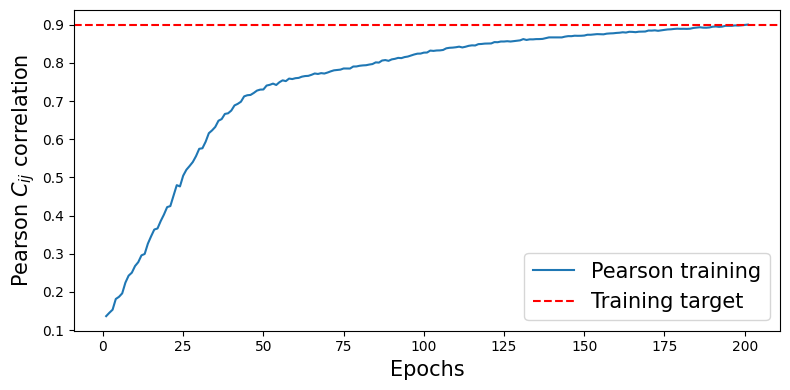

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=100)
ax.plot(history["epochs"], history["pearson"], label="Pearson training")
ax.axhline(target, ls="--", color="red", label="Training target")
ax.set_xlabel("Epochs", fontsize=15)
ax.set_ylabel(r"Pearson $C_{ij}$ correlation", fontsize=15)
ax.legend(fontsize=15)
fig.tight_layout()

In [36]:
from adabmDCA.plot import plot_PCA

fig = plt.figure(figsize=(6, 6), dpi=96)
fig = plot_PCA(
    fig=fig,
    data1=msa_proj.cpu().numpy(),
    data2=gen_proj.cpu().numpy(),
    title="",
    labels=["data", "generated"],
    pc1=0,
    pc2=1
)

ModuleNotFoundError: No module named 'seaborn'